# PLOT THE DATA

### Screening

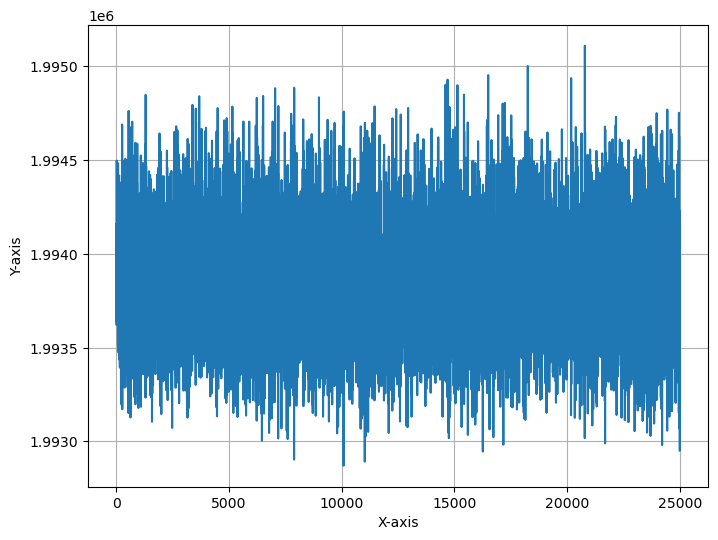

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def read_xvg(file_path):
    """
    Reads a .xvg file and extracts data, skipping comments and metadata.

    Args:
        file_path (str): Path to the .xvg file.

    Returns:
        tuple: A tuple containing two numpy arrays for x and y data.
    """
    x = []
    y = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or line.startswith('@'):
                # Skip comments and metadata lines
                continue
            split_line = line.split()
            if len(split_line) >= 2:
                x.append(float(split_line[0]))
                y.append(float(split_line[1]))

    return np.array(x), np.array(y)

def plot_xvg_data(file_path, title="", xlabel="X-axis", ylabel="Y-axis"):
    """
    Reads and plots data from a .xvg file.

    Args:
        file_path (str): Path to the .xvg file.
        title (str): Plot title.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis.
    """
    x, y = read_xvg(file_path)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label='Data', linewidth=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

# Example usage:
# Replace 'example.xvg' with the path to your .xvg file
file_path = "/home/newsitt/Desktop/dlic_20ns/prd-ep.xvg"
plot_xvg_data(file_path)

,Metric,Value
0,Mean Potential Energy,1.994112e+06
1,Standard Deviation,1.773983e+02
2,Coefficient of Variation (%),8.896106e-03
3,Standard Error,2.508540e+00



🔍 Equilibration Status:
✅ The system is equilibrated based on statistical metrics.


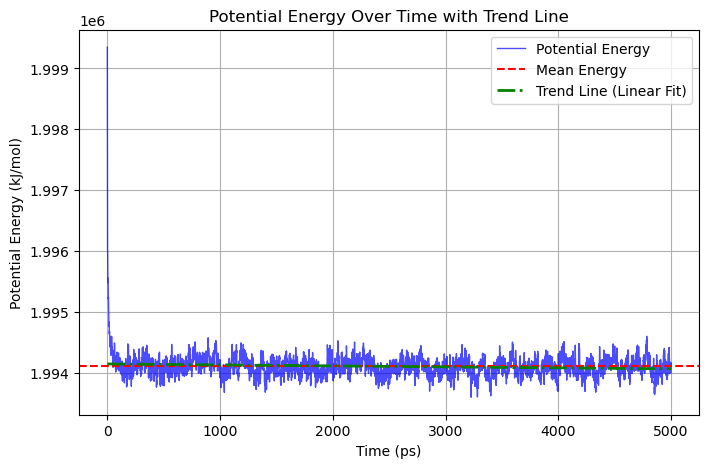

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define file path (Update if needed)
#file_path = "/home/newsitt/Desktop/dtac_20ns/prd-t.xvg"
file_path = "nvt-ep.xvg"

# Load data while ignoring metadata lines (comments starting with "@" or "#")
try:
    data = np.loadtxt(file_path, comments=["@", "#"])
except Exception as e:
    print(f"Error reading file: {e}")
    data = None

if data is not None:
    # Extract time (first column) and potential energy (second column)
    time = data[:, 0]
    potential_energy = data[:, 1]

    # Compute statistical metrics
    mean_potential_energy = np.mean(potential_energy)
    std_potential_energy = np.std(potential_energy)
    cv_potential_energy = (std_potential_energy / mean_potential_energy) * 100  # Coefficient of Variation (%)
    standard_error_potential_energy = std_potential_energy / np.sqrt(len(potential_energy))

    # Define equilibration criteria
    equilibration_criteria = {
        "std_threshold": 500,   # Standard deviation should be < 500 kJ/mol
        "cv_threshold": 1.0,    # Coefficient of Variation (%) should be < 1%
        "se_threshold": 5.0     # Standard Error should be < 5 kJ/mol
    }

    # Check if the system is equilibrated
    is_equilibrated = (
        std_potential_energy < equilibration_criteria["std_threshold"] and
        cv_potential_energy < equilibration_criteria["cv_threshold"] and
        standard_error_potential_energy < equilibration_criteria["se_threshold"]
    )

    # Generate equilibration message
    if is_equilibrated:
        equilibration_message = "✅ The system is equilibrated based on statistical metrics."
    else:
        equilibration_message = "❌ The system is NOT equilibrated yet. Consider extending the equilibration time."

    # Create a summary dictionary
    summary_potential_energy = {
        "Metric": ["Mean Potential Energy", "Standard Deviation", "Coefficient of Variation (%)", "Standard Error"],
        "Value": [mean_potential_energy, std_potential_energy, cv_potential_energy, standard_error_potential_energy]
    }

    # Convert to DataFrame for display
    df_summary = pd.DataFrame(summary_potential_energy)

    # Display the summary table
    from IPython.display import display
    display(df_summary)

    # Print equilibration status
    print("\n🔍 Equilibration Status:")
    print(equilibration_message)

    # Perform linear regression for trend line
    slope, intercept, _, _, _ = linregress(time, potential_energy)
    trend_line = slope * time + intercept

    # Plot potential energy over time with trend line
    plt.figure(figsize=(8, 5))
    plt.plot(time, potential_energy, label="Potential Energy", color="b", linewidth=1, alpha=0.7)
    plt.axhline(mean_potential_energy, color="r", linestyle="--", label="Mean Energy")
    plt.plot(time, trend_line, color="g", linestyle="-.", linewidth=2, label="Trend Line (Linear Fit)")
    plt.xlabel("Time (ps)")
    plt.ylabel("Potential Energy (kJ/mol)")
    plt.title("Potential Energy Over Time with Trend Line")
    plt.legend()
    plt.grid()
    plt.show()


### Mean Square Displacement (MSD)

Plot saved as: /home/newsitt/Desktop/bdac_20ns/msd_bdac.png


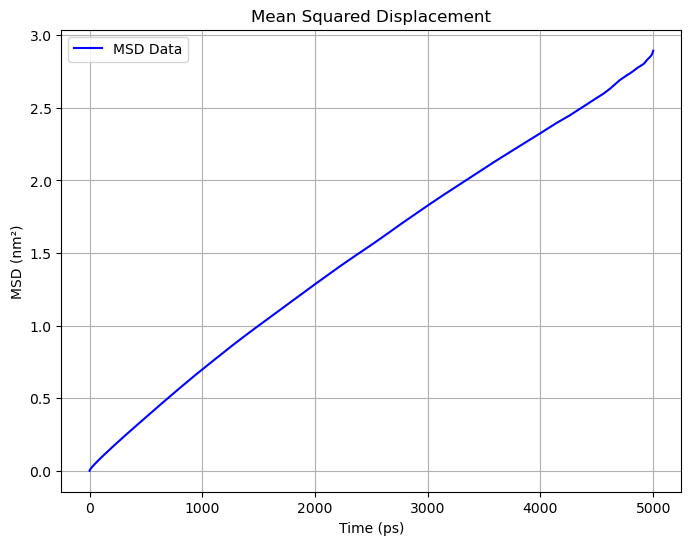

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def read_msd_xvg(file_path):
    """
    Reads a GROMACS MSD .xvg file and extracts time and MSD values.

    Args:
        file_path (str): Path to the .xvg file.

    Returns:
        tuple: Two numpy arrays (time, MSD).
    """
    time = []
    msd = []

    try:
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('#') or line.startswith('@'):
                    continue  # Skip comments and metadata lines

                split_line = line.split()
                if len(split_line) >= 2:  # Ensure there are enough columns
                    time.append(float(split_line[0]))  # Time (ps)
                    msd.append(float(split_line[1]))   # MSD (nm²)

        if not time or not msd:
            raise ValueError("No valid MSD data found in the file.")

    except Exception as e:
        print(f"Error reading file: {e}")
        return None, None

    return np.array(time), np.array(msd)

def plot_msd(file_path, title="Mean Squared Displacement", xlabel="Time (ps)", ylabel="MSD (nm²)", save_path=None):
    """
    Reads and plots Mean Squared Displacement (MSD) data from a GROMACS .xvg file.

    Args:
        file_path (str): Path to the MSD .xvg file.
        title (str): Plot title.
        xlabel (str): Label for the X-axis.
        ylabel (str): Label for the Y-axis.
        save_path (str, optional): Path to save the figure. If None, the plot is displayed.
    """
    time, msd = read_msd_xvg(file_path)
    if time is None or msd is None:
        return  # Exit if no valid data

    plt.figure(figsize=(8, 6))
    plt.plot(time, msd, label='MSD Data', linewidth=1.5, color='b')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved as: {save_path}")
    else:
        plt.show()

# Example usage:
#file_path = "/home/newsitt/Desktop/bdac_20ns/msd_bdac.xvg"  # Replace with your actual MSD file
file_path = "msd-nvt.xvg"
plot_msd(file_path, save_path="/home/newsitt/Desktop/bdac_20ns/msd_bdac.png")


### Diffusion Coefficient

Estimated Diffusion Coefficient: 0.00002 nm²/ps (1.73794e-11 cm²/s)


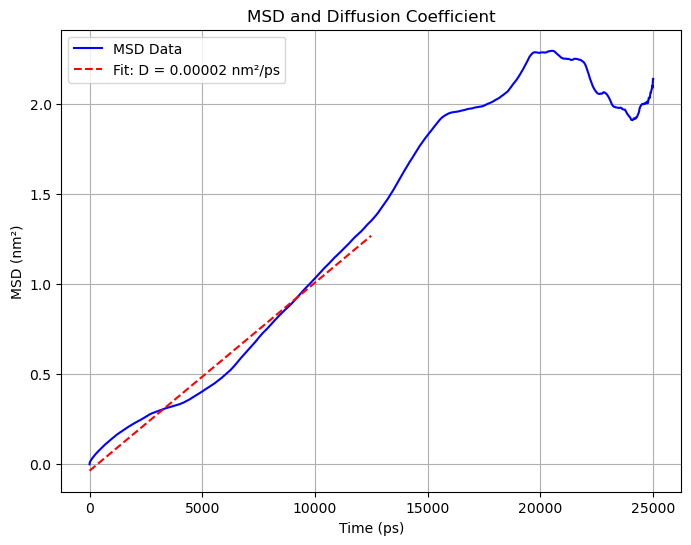

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def read_xvg(file_path):
    time, msd = [], []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or line.startswith('@'):
                continue
            split_line = line.split()
            time.append(float(split_line[0]))  # Time (ps)
            msd.append(float(split_line[1]))   # MSD (nm²)
    return np.array(time), np.array(msd)

# Load MSD data
file_path = "/home/newsitt/Desktop/dlic_20ns/msd_dlic.xvg"
time, msd = read_xvg(file_path)

# Fit MSD in the linear region
fit_range = len(time) // 2  # Adjust based on data
slope, intercept, r_value, p_value, std_err = linregress(time[:fit_range], msd[:fit_range])

# Compute Diffusion Coefficient
D = slope / 6  # nm²/ps
D_cm2_s = D * 1e-6  # Convert to cm²/s

print(f"Estimated Diffusion Coefficient: {D:.5f} nm²/ps ({D_cm2_s:.5e} cm²/s)")

# Plot MSD with fit
plt.figure(figsize=(8, 6))
plt.plot(time, msd, label="MSD Data", linewidth=1.5, color='b')
plt.plot(time[:fit_range], slope * time[:fit_range] + intercept, '--r', label=f"Fit: D = {D:.5f} nm²/ps")
plt.xlabel("Time (ps)")
plt.ylabel("MSD (nm²)")
plt.title("MSD and Diffusion Coefficient")
plt.legend()
plt.grid(True)
plt.show()

### Minimum Distance

📌 Average Minimum Distance: 0.224 nm


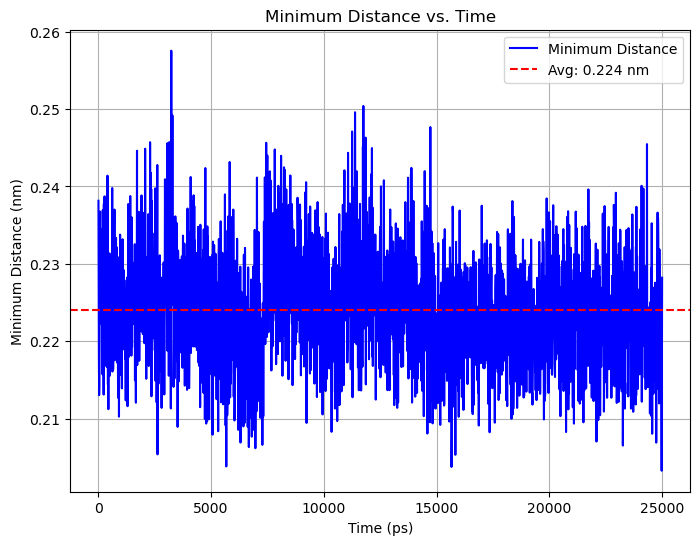

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def read_xvg(file_path):
    """
    Reads a GROMACS .xvg file and extracts time and minimum distance values.

    Args:
        file_path (str): Path to the .xvg file.

    Returns:
        tuple: Two numpy arrays (time, distance).
    """
    time, distance = [], []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#') or line.startswith('@'):
                continue  # Skip comments and metadata lines
            split_line = line.split()
            time.append(float(split_line[0]))  # Time (ps)
            distance.append(float(split_line[1]))  # Minimum Distance (nm)
    return np.array(time), np.array(distance)

# 📌 Replace with your actual file path
file_path = "/home/newsitt/Desktop/bdac_20ns/mindist_bdac.xvg"

# Read data
time, distance = read_xvg(file_path)

# Compute average minimum distance
avg_distance = np.mean(distance)

# Plot Minimum Distance
plt.figure(figsize=(8, 6))
plt.plot(time, distance, label="Minimum Distance", linewidth=1.5, color='b')
plt.axhline(y=avg_distance, color='r', linestyle='--', label=f"Avg: {avg_distance:.3f} nm")
plt.xlabel("Time (ps)")
plt.ylabel("Minimum Distance (nm)")
plt.title("Minimum Distance vs. Time")
plt.legend()
plt.grid(True)

# Display the average value in Jupyter Notebook
print(f"📌 Average Minimum Distance: {avg_distance:.3f} nm")

# Show plot
plt.show()


## MDAnalysis

In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis.msd import EinsteinMSD
import matplotlib.pyplot as plt
import numpy as np

# Define paths to trajectory and topology files
topology_file = "/home/newsitt/Desktop/dtac_20ns/prd.gro"
trajectory_file = "/home/newsitt/Desktop/dtac_20ns/prd-mol.xtc"

# Load trajectory and topology
try:
    u = mda.Universe(topology_file, trajectory_file)
    print("Trajectory loaded successfully!")
except Exception as e:
    print(f"Error loading trajectory: {e}")
    exit()

# Select the atom group for MSD calculation (Modify as needed)
atom_group = u.select_atoms("all")  # Example: all atoms
print(f"Selected {len(atom_group)} atoms for MSD analysis.")

# Compute MSD using MDAnalysis
msd_analysis = EinsteinMSD(atom_group, msd_type='xyz', fft=True)
msd_analysis.run()

# Check available result attributes
print("Available MSD result keys:", msd_analysis.results.keys())

# Extract time (ps) and MSD (nm²)
time = msd_analysis.times
if hasattr(msd_analysis.results, "msd"):
    msd = msd_analysis.results.msd
elif hasattr(msd_analysis.results, "msds"):
    msd = msd_analysis.results.msds
else:
    print("Error: MSD results not found in the output.")
    exit()

# Plot MSD
plt.figure(figsize=(8, 6))
plt.plot(time, msd, label='MSD (All Atoms)', linewidth=1.5, color='b')
plt.xlabel("Time (ps)")
plt.ylabel("MSD (nm²)")
plt.title("Mean Squared Displacement (MSD) Analysis")
plt.legend()
plt.grid(True)

# Save plot (optional)
save_path = "msd_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Plot saved as: {save_path}")

# Show plot
plt.show()


Trajectory loaded successfully!
Selected 2429 atoms for MSD analysis.


100%|██████████| 2429/2429 [00:04<00:00, 504.65it/s]


Available MSD result keys: KeysView({'msds_by_particle': array([[ 9.09494702e-13,  0.00000000e+00,  2.91038305e-11, ...,
         0.00000000e+00, -9.31322575e-10, -9.31322575e-10],
       [ 0.00000000e+00, -3.55271368e-15, -2.84217094e-14, ...,
         2.24369574e+01,  2.26822933e+01,  4.98320494e+01],
       [ 0.00000000e+00, -3.55271368e-15, -1.42108547e-14, ...,
         3.20265454e+01,  3.21588388e+01,  5.74080679e+01],
       ...,
       [-1.66360259e-11, -7.79248666e-10,  2.82236101e-09, ...,
         8.00058595e+01,  8.59206875e+01,  9.33407019e+02],
       [-2.49258392e-11, -1.17086074e-09,  4.23881374e-09, ...,
         8.21407951e+01,  9.04192425e+01,  8.18842181e+02],
       [-4.99085218e-11, -2.34598474e-09,  8.49519211e-09, ...,
         7.29017829e+01,  8.07624797e+01,  3.78335830e+02]]), 'timeseries': array([-2.34705423e-10,  2.96344332e+01,  3.72353915e+01, ...,
        2.29076315e+02,  2.31088527e+02,  2.33034670e+02])})
Error: MSD results not found in the output.


NameError: name 'msd' is not defined

<Figure size 800x600 with 0 Axes>

: 